In [368]:
import numpy as np
import pandas as pd
import datetime as dt
import urllib.request as urlreq
import json
import os
#os.chdir('.\ModelWeights')

from matplotlib import pyplot
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import concatenate

In [432]:
### Collecting VIX and SPX index data from CBOE and Yahoo Finance

# VIX Data Collection
curr_vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', 
                       skiprows = 1, index_col = 0)
curr_vix.index = pd.to_datetime(curr_vix.index)

hist_vix = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixarchive.xls',
                         skiprows = 1, index_col = 0)
hist_vix.index = pd.to_datetime(hist_vix.index)

vix = pd.concat([hist_vix,curr_vix], axis = 0)

# SPX Data Collection
ticker = '^GSPC'
start_date = dt.datetime(1990,1,1)
end_date = end_date = dt.datetime.today()

start_date_unix = int(start_date.timestamp())
end_date_unix = int(end_date.timestamp())

hist_price_url = 'https://query1.finance.yahoo.com/v8/finance/chart/{0}?symbol={0}&period1={1}&period2={2}&interval=1d'.format(ticker,start_date_unix,end_date_unix)

with urlreq.urlopen(hist_price_url) as url:
    data = json.loads(url.read().decode())
    hist_prices = pd.DataFrame({**data['chart']['result'][0]['indicators']['quote'][0], **data['chart']['result'][0]['indicators']['adjclose'][0]},
                               index = [dt.datetime.utcfromtimestamp(int(x)).date() for x in data['chart']['result'][0]['timestamp']])
    hist_prices.index = pd.to_datetime(hist_prices.index)
    hist_prices.columns = ["{0}_{1}".format(ticker.replace('^',''), x) for x in hist_prices.columns]


In [461]:
# Joining both VIX and SPX data into one dataframe and backfilling null values
data = pd.concat([hist_prices[['GSPC_close']], vix[['VIX Close']]], 
                 axis = 1).replace('n/a',np.nan).apply(lambda x: pd.to_numeric(x)).fillna(method = 'ffill')
data.columns = [col.replace(' ','_') for col in data.columns.tolist()]

# Dividing VIX_Close by 100 given the index is a measure of implied future volatility
data['VIX_Close'] = data['VIX_Close']/100

# Calculating 20 Trading Day Rolling Realized Annualized Volatility for the SPX Index

data['RV'] = np.log(data['GSPC_close']/data['GSPC_close'].shift(1)).rolling(window = 20).std()*np.sqrt(252)

# Returns for 20 Day for the SPX Index
data['Return_20D'] = data.GSPC_close.pct_change(20)
    
# Short Period vs Long Period Simple Moving Average Measure
short_window = 20
long_window = 200
data['ShortVLongSMA'] = data.GSPC_close.rolling(window = short_window).mean()/data.GSPC_close.rolling(window = long_window).mean() - 1

data['Max_DD_Period'] = data.GSPC_close/data.GSPC_close.rolling(window = 20).max() - 1
data['Max_DD_Period'] = data['Max_DD_Period'].rolling(window = 20).min()
data = data.dropna().iloc[:,1:]

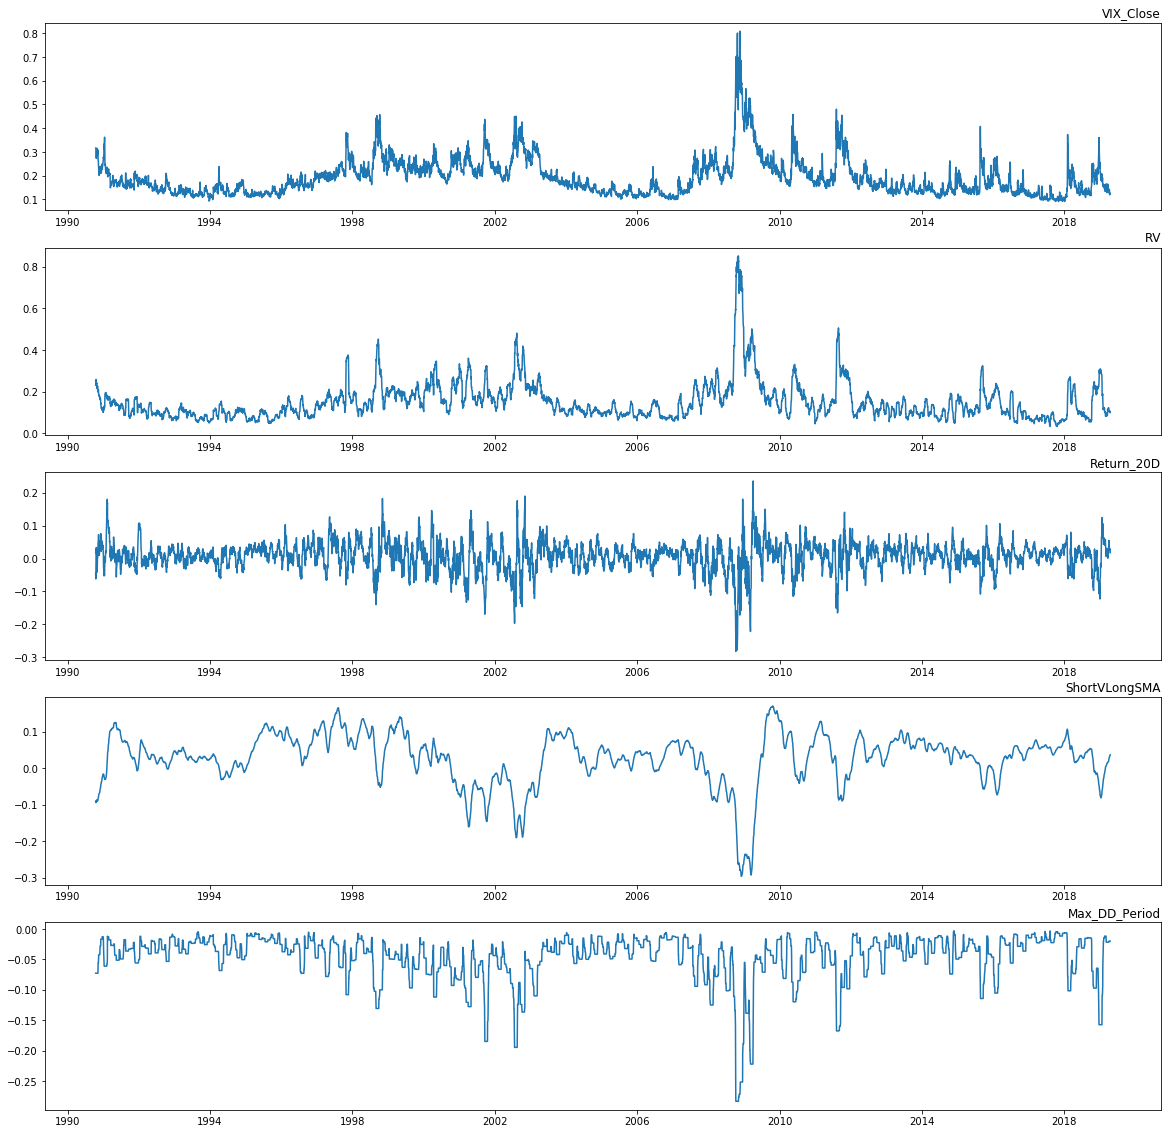

In [463]:
# Plotting Time Series of Features

pyplot.figure(figsize = (20,20))
for variable in range(data.shape[1]):
    pyplot.subplot(data.shape[1], 1, variable + 1)
    pyplot.plot(data.iloc[:, variable])
    pyplot.title(data.columns[variable], y = 1, loc = 'right')

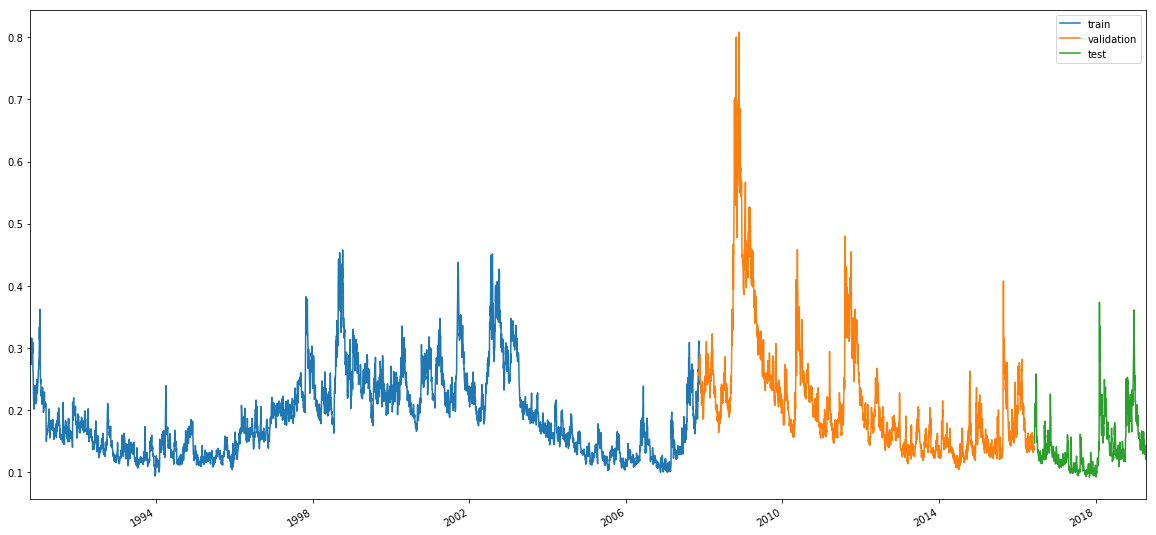

In [464]:
# LSTM Data Preparation

# Converting time series to supervised learning data
# Predicting t = 1 Day out
timesteps = 1

data['VIX_Forecast'] = data['VIX_Close'].shift(-timesteps)
data = data.dropna()

# Splitting Data into Training, Validation, and Test sets
train_pct = 0.6
validation_pct = 0.3

train = data.iloc[:round(len(data)*train_pct),:]
validation = data.iloc[len(train):len(train) + round(len(data)*validation_pct), :]
test = data[data.index > validation.index[-1]]

# Plotting the data sets
pyplot.figure(figsize=(20, 10))
ax = train.VIX_Close.plot()
validation.VIX_Close.plot(ax=ax)
test.VIX_Close.plot(ax=ax)
pyplot.legend(['train', 'validation', 'test'])

In [466]:
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))

# # Fit transform on training data
# train_scaled = scaler.fit_transform(train)

# # Normalize data using fitted transform from training data
# validation_scaled = scaler.transform(validation)
# test_scaled = scaler.transform(test)

# # Splitting into input and outputs
# train_x, train_y = train_scaled[:, :-1], train_scaled[:, -1]
# validation_x, validation_y = validation_scaled[:, :-1], validation_scaled[:, -1]
# test_x, test_y = test_scaled[:, :-1], test_scaled[:, -1]

# Splitting into input and outputs
train_x, train_y = train.values[:, :-1], train.values[:, -1]
validation_x, validation_y = validation.values[:, :-1], validation.values[:, -1]
test_x, test_y = test.values[:, :-1], test.values[:, -1]

# Reshaping data to be 3D [samples, timesteps, features] for tensor operations

train_x = train_x.reshape((train_x.shape[0], timesteps, train_x.shape[1]))
validation_x = validation_x.reshape((validation_x.shape[0], timesteps, validation_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], timesteps, test_x.shape[1]))
print(train_x.shape, train_y.shape, validation_x.shape, validation_y.shape, test_x.shape, test_y.shape)

(4310, 1, 5) (4310,) (2155, 1, 5) (2155,) (719, 1, 5) (719,)


Train on 4310 samples, validate on 2155 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.14743, saving model to vix_mae_weights.hdf5
4310/4310 - 1s - loss: 0.1648 - val_loss: 0.1474
Epoch 2/100

Epoch 00002: val_loss improved from 0.14743 to 0.06540, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0849 - val_loss: 0.0654
Epoch 3/100

Epoch 00003: val_loss improved from 0.06540 to 0.05078, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0438 - val_loss: 0.0508
Epoch 4/100

Epoch 00004: val_loss improved from 0.05078 to 0.04772, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0426 - val_loss: 0.0477
Epoch 5/100

Epoch 00005: val_loss improved from 0.04772 to 0.04495, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0409 - val_loss: 0.0450
Epoch 6/100

Epoch 00006: val_loss improved from 0.04495 to 0.04224, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0390 - val_loss: 0.0422
Epoch 7/100

Epoch 00007: 

Epoch 54/100

Epoch 00054: val_loss improved from 0.01677 to 0.01652, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0195 - val_loss: 0.0165
Epoch 55/100

Epoch 00055: val_loss improved from 0.01652 to 0.01639, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0189 - val_loss: 0.0164
Epoch 56/100

Epoch 00056: val_loss improved from 0.01639 to 0.01616, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0189 - val_loss: 0.0162
Epoch 57/100

Epoch 00057: val_loss improved from 0.01616 to 0.01597, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0182 - val_loss: 0.0160
Epoch 58/100

Epoch 00058: val_loss improved from 0.01597 to 0.01573, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0187 - val_loss: 0.0157
Epoch 59/100

Epoch 00059: val_loss improved from 0.01573 to 0.01556, saving model to vix_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0189 - val_loss: 0.0156
Epoch 60/100

Epoch 00060: val_loss improved from 0.01556 to 0.0

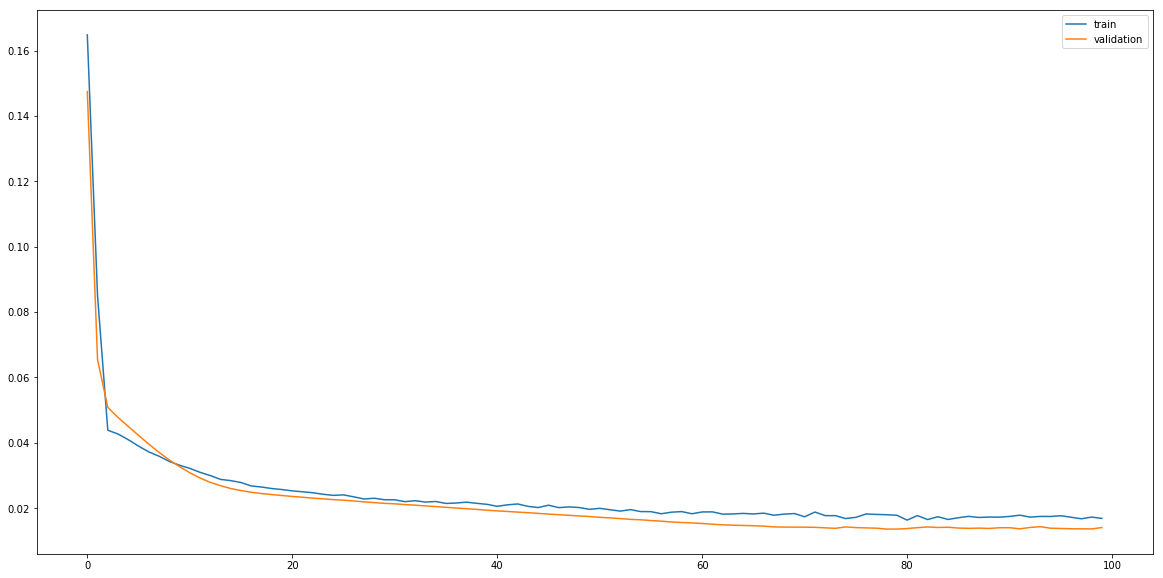

In [513]:
# design network
# 50 neurons with 100 Epochs with batch size of 200
neurons = 30
n_epochs = 100
batchsize = 200

model = Sequential()
# model.add(LSTM(neurons, input_shape=(train_x.shape[1], train_x.shape[2]), activation = 'tanh',
#                recurrent_activation='hard_sigmoid', dropout=0.1, recurrent_dropout=0.1))
model.add(LSTM(neurons, input_shape=(train_x.shape[1], train_x.shape[2]), activation = 'tanh',
               dropout=0.05))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
checkpointer = ModelCheckpoint(filepath="vix_mae_weights.hdf5", verbose=1, save_best_only=True)

history = model.fit(train_x, train_y, epochs = n_epochs, 
                    batch_size = batchsize, validation_data=(validation_x, validation_y), 
                    verbose=2, shuffle=False, callbacks = [checkpointer])
# plot history
pyplot.figure(figsize=(20, 10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [514]:
# make a prediction
yhat_validation = model.predict(validation_x).reshape(validation_y.shape)
yhat_test = model.predict(test_x).reshape(test_y.shape)

# # invert scaling for forecast
# inv_yhat_validation = np.concatenate((yhat_validation, 
#                                       validation_x.reshape((validation_x.shape[0], validation_x.shape[2]))), 
#                                      axis = 1)
# inv_yhat_validation = scaler.inverse_transform(inv_yhat_validation)
# inv_yhat_validation = inv_yhat_validation[:,0]

# inv_yhat_test = np.concatenate((yhat_test, 
#                                 test_x.reshape((test_x.shape[0], test_x.shape[2]))), 
#                                axis = 1)
# inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
# inv_yhat_test = inv_yhat_test[:,0]

# # invert scaling for actual
# inv_y_validation = np.concatenate((validation_y.reshape((len(validation_y), 1)), 
#                                    validation_x.reshape((validation_x.shape[0], validation_x.shape[2]))), axis = 1)
# inv_y_validation = scaler.inverse_transform(inv_y_validation)
# inv_y_validation = inv_y_validation[:,0]

# inv_y_test = np.concatenate((test_y.reshape((len(test_y), 1)), 
#                              test_x.reshape((test_x.shape[0], test_x.shape[2]))), axis = 1)
# inv_y_test = scaler.inverse_transform(inv_y_test)
# inv_y_test = inv_y_test[:,0]


# calculate RMSE
rmse_validation = np.sqrt(mean_squared_error(validation_y, yhat_validation))
rmse_test = np.sqrt(mean_squared_error(test_y, yhat_test))
print('Validation RMSE: %.3f' % rmse_validation)
print('Test RMSE: %.3f' % rmse_test)

Validation RMSE: 0.023
Test RMSE: 0.016


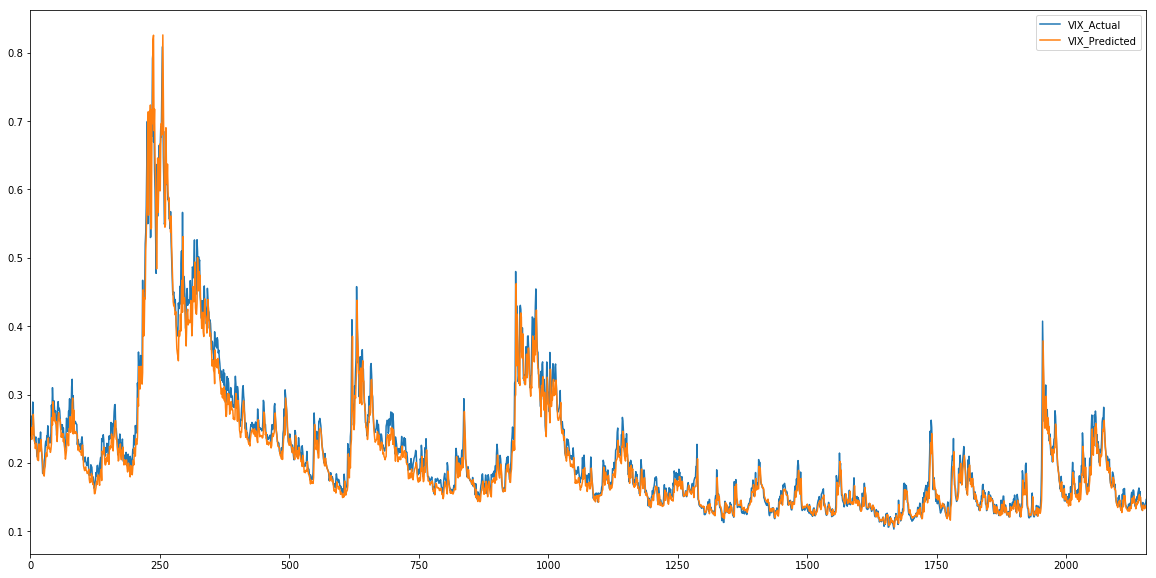

In [519]:
# validation_performance = validation[['VIX_Forecast']]
# validation_performance.columns = ['VIX_Close']
# validation_performance['VIX_Prediction'] = inv_yhat_validation
# validation_performance = validation_performance.shift(1).dropna()
# validation_performance.plot(figsize = (20,10))
validation_performance = pd.DataFrame({'VIX_Actual': validation_y,
                                       'VIX_Predicted': yhat_validation})
validation_performance.plot(figsize = (20,10))

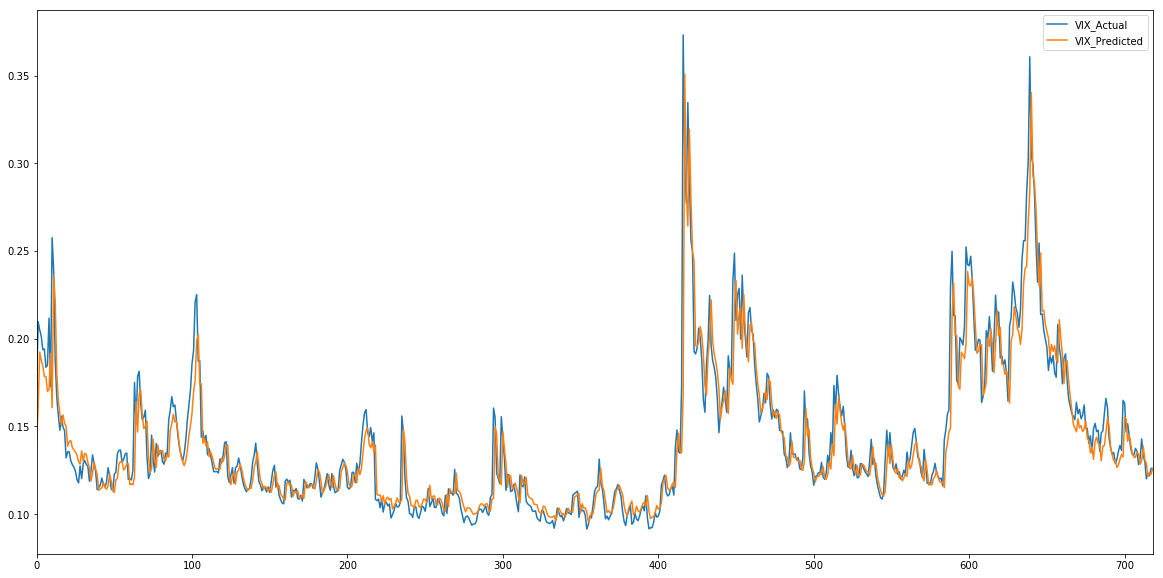

In [516]:
test_performance = pd.DataFrame({'VIX_Actual': test_y,
                                 'VIX_Predicted': yhat_test})
test_performance.plot(figsize = (20,10))

### Links
- https://www.datacamp.com/community/tutorials/lstm-python-stock-market
- https://codeburst.io/neural-networks-for-algorithmic-trading-volatility-forecasting-and-custom-loss-functions-c030e316ea7e
- https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-part-one-simple-time-series-forecasting-f992daa1045a
- https://towardsdatascience.com/an-introduction-on-time-series-forecasting-with-simple-neura-networks-lstm-f788390915b
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://github.com/guillaume-chevalier/seq2seq-signal-prediction
- https://gist.github.com/lukovkin/1aefa4509e066690b892
- https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679